In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# fix random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model specification

In [3]:
class AE(nn.Module):
	def __init__(self, depth):
		super().__init__()
		if depth == 2:
			self.encoder = nn.Sequential(
				nn.Linear(784, 10),
				nn.ReLU(),
				nn.Linear(10, 2)
			)
			self.decoder = nn.Sequential(
				nn.Linear(2, 10),
				nn.ReLU(),
				nn.Linear(10, 784),
			)
		elif depth == 3:
			self.encoder = nn.Sequential(
				nn.Linear(784, 10),
				nn.ReLU(),
				nn.Linear(10, 10),
				nn.ReLU(),
				nn.Linear(10, 2)
			)
			self.decoder = nn.Sequential(
				nn.Linear(2, 10),
				nn.ReLU(),
				nn.Linear(10, 10),
				nn.ReLU(),
				nn.Linear(10, 784),
			)

	def encode(self, x):
		return self.encoder(x)

	def decode(self, z):
		return self.decoder(z)

	def forward(self, x):
		return self.decode(self.encode(x))


## Data

In [4]:
batch_size = 128
lr = 3e-4
log_interval = 10
num_epochs = 15

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("data", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [6]:
indexes = dict()
for index, target in enumerate(dataset1.targets.tolist()):
    if target not in indexes:
        indexes[target] = [index]
    else:
        indexes[target].append(index)

In [7]:
subsampled_indexes = dict()
for i in range(10):
    subsampled_indexes[i] = []
subsampled_data = []
subsampled_target = []
for key, sub_indexes in indexes.items():
    np_sub_indexes = np.random.choice(sub_indexes, 50, replace=False)
    subsampled_indexes[key] = np_sub_indexes
    for index in np_sub_indexes:
        data, target = dataset1.__getitem__(index)
        subsampled_data.append(torch.flatten(data))
        subsampled_target.append(target)
    

subsampled_data = torch.stack(subsampled_data)
subsampled_target = torch.tensor(subsampled_target)
subsampled_data.shape, subsampled_target.shape

(torch.Size([500, 784]), torch.Size([500]))

## Basic optimization loop

In [8]:
# TODO
model = AE(2)
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()
for epoch in range(num_epochs):
	for data, _ in train_loader:
		data = data.view(data.size(0), -1)
		optimizer.zero_grad()
		output = model(data)
		loss = criterion(output, data)
		loss.backward()
		optimizer.step()

In [9]:
embeddings1 = model.encode(subsampled_data).detach().numpy()

In [10]:
# TODO
model = AE(3)
optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = nn.MSELoss()
for epoch in range(num_epochs):
	for data, _ in train_loader:
		data = data.view(data.size(0), -1)
		optimizer.zero_grad()
		output = model(data)
		loss = criterion(output, data)
		loss.backward()
		optimizer.step()

In [11]:
embeddings2 = model.encode(subsampled_data).detach().numpy()

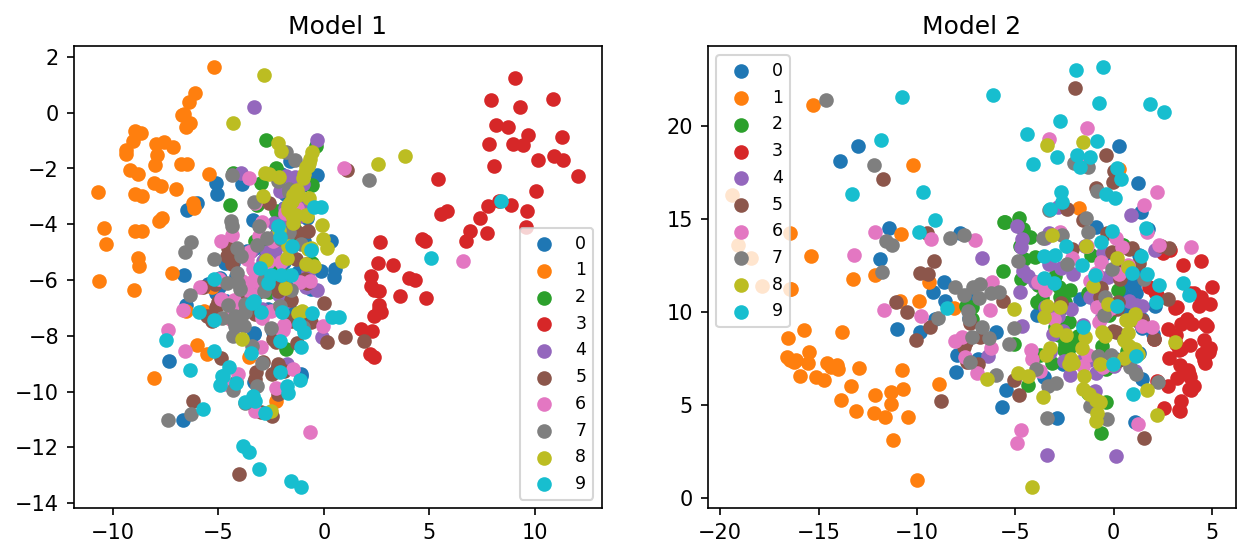

In [12]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
cmap = plt.get_cmap("tab10")
axs[0].set_title("Model 1")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[0].scatter(embeddings1[50*i: 50*(i+1), 0], embeddings1[50*i: 50*(i+1), 1], color=color, label=key)
axs[0].legend(fontsize="small")
axs[1].set_title("Model 2")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[1].scatter(embeddings2[50*i: 50*(i+1), 0], embeddings2[50*i: 50*(i+1), 1], color=color, label=key)
axs[1].legend(fontsize="small")
plt.show()